In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
from statistics import mode
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
import sys
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import utm_to_epsg, get_coincident


# Configure input

In [2]:
# User input
config = {}
s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'Data' # data folder
em_intype = 'LIN'   # 'reca' = rECa EMI data; 'lin' = LIN ECa EMI data; 
cal = 'calibrated' # 'non_calibrated'
config['instrument_code'] = 'Dualem-41HS'

## Load data

In [3]:
if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'

cal_folder = os.path.join(datafolder, 'calibrated')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_{cal}_{em_intype}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')
inv_s = os.path.join(datafolder, f'{profile_prefix}_inverted_samples.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
inverted = pd.read_csv(inv_s, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)
em_samples = get_coincident(em_survey,samples)

# Data Analysis
### Data wrangling

In [4]:
ds_c = em_samples.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

In [5]:
inv_columns = inverted.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds_c.loc[ds_c.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000

ds_c.to_csv('ds_c.csv')

### Correlations

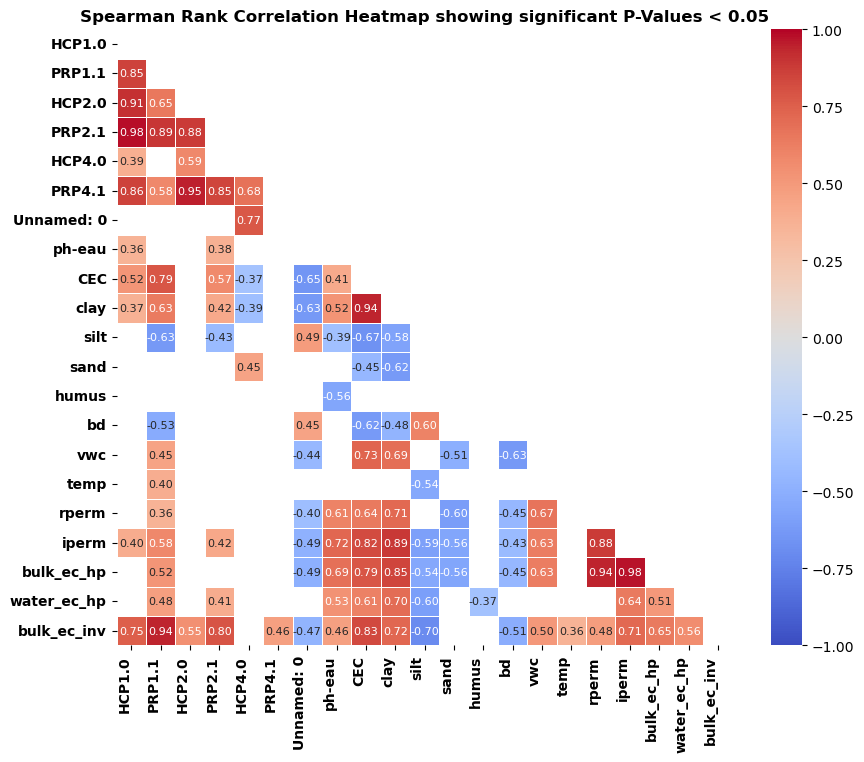

In [6]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds_c.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds_c[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.05
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot
plt.show()


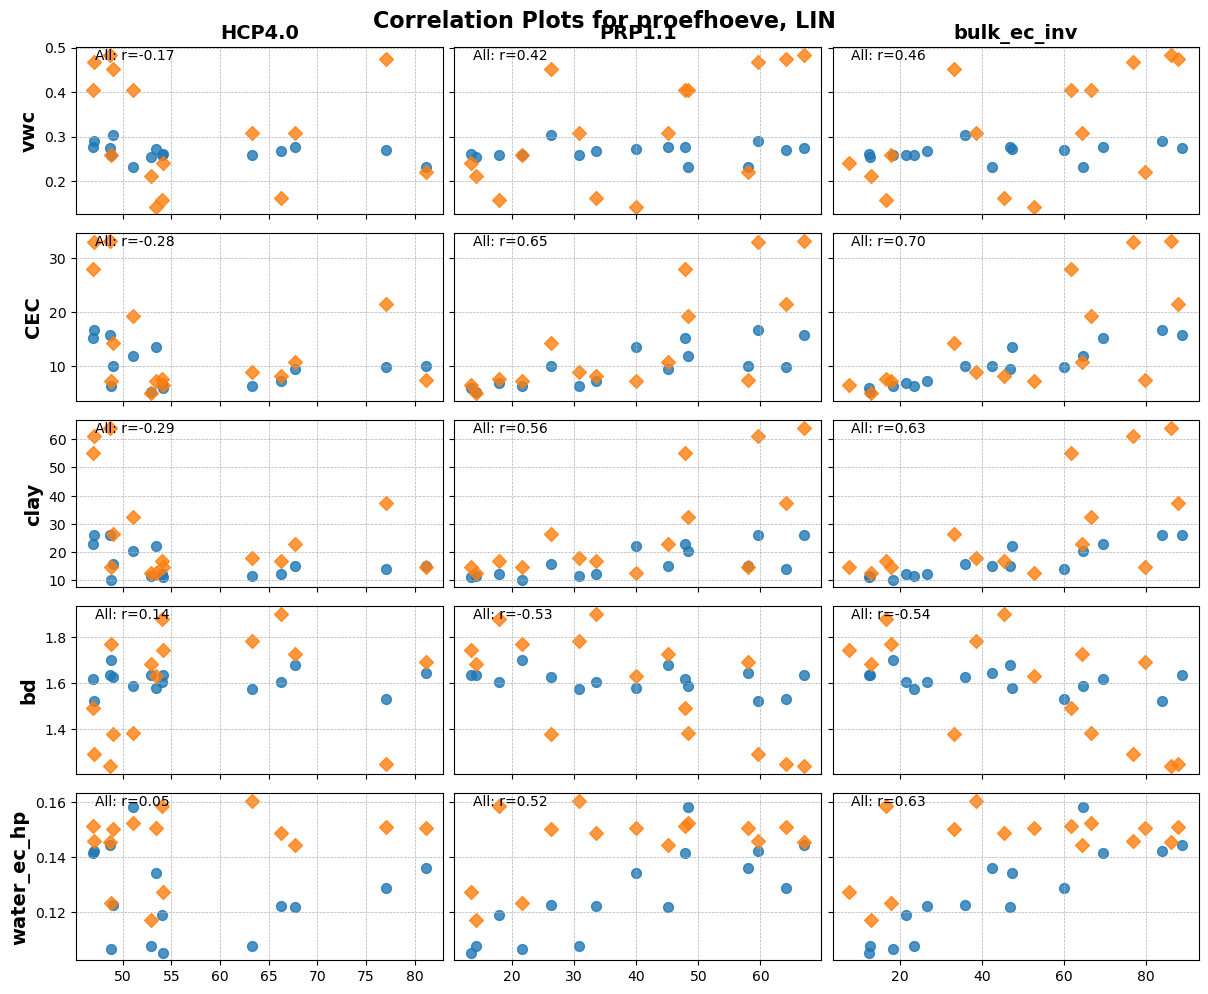

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
ss = 50  # Reduced size for scatter points

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp']
preds = ['HCP4.0', 'PRP1.1', 'bulk_ec_inv']

def corr_plot(df, preds, targets):
    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])

            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

corr_plot(ds_c, preds, targets)
plt.suptitle(f"Correlation Plots for {profile_prefix}, {em_intype}", fontweight='bold', fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

# Modelling

### Deterministic approach

In [8]:
clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc)

feature_set = [
    'HCP1.0',
    'HCP2.0',
    'HCP4.0',
    'PRP1.1',
    'PRP2.1',
    'PRP4.1',
    'bulk_ec_inv',
#    'bulk_ec_dc_tc_inv',
#    'bulk_ec_hp',
#    'bulk_ec_dc_tc_hp'
]

In [9]:
def deterministic(X, Y, ds_c, iters=100, round_n=3):
    R2_wat_lt, RMSE_wat_lt, wat_lt_ = [], [], []
    R2_wat_ls, RMSE_wat_ls, wat_ls_ = [], [], []
    ideal_wat_, R2_wat_ideal, RMSE_wat_ideal = [], [], []

    # Generate indices for X
    indices = np.arange(len(X))

    for i in range(iters):
        ds_c.reset_index(drop=True, inplace=True)
        # Split the data and indices
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.3, random_state=i)

        layers_together = Soil( 
                    bulk_ec = X_test.values/1000,
                    frequency_ec=9000,
                    clay = clay_mean,
                    bulk_density = bd_mean,
                    water_ec = water_ec_hp_mean,
                    temperature = temp_mean+273.15
                      )
        
        wat_lt = predict.Water(layers_together)
        wat_lt_.append(wat_lt)
        r2_lt = round(r2_score(y_test, wat_lt), round_n)
        rmse_lt = round(RMSE(y_test, wat_lt), round_n)
        R2_wat_lt.append(r2_lt)
        RMSE_wat_lt.append(rmse_lt)

        # Use idx_test to filter ds_c
        filtered_ds_c = ds_c.loc[idx_test]

        ideal =  Soil( 
                    bulk_ec = X_test.values/1000,
                    frequency_ec=9000,
                    clay = filtered_ds_c['clay'].values,
                    bulk_density = filtered_ds_c['bd'].values,
                    water_ec = filtered_ds_c['water_ec_hp'].values,
                    temperature = filtered_ds_c['temp'].values+273.15
                      )
        
        ideal_wat = predict.Water(ideal)
        ideal_wat_.append(ideal_wat)
        r2_ideal = round(r2_score(y_test, ideal_wat), round_n)
        rmse_ideal = round(RMSE(y_test, ideal_wat), round_n)
        R2_wat_ideal.append(r2_ideal)
        RMSE_wat_ideal.append(rmse_ideal)

        mask_test_10 = filtered_ds_c[filtered_ds_c['depth'] == 10].index.tolist()
        mask_test_50 = filtered_ds_c[filtered_ds_c['depth'] == 50].index.tolist()

        positions_test_10 = [np.where(idx_test == idx)[0][0] for idx in mask_test_10 if idx in idx_test]
        positions_test_50 = [np.where(idx_test == idx)[0][0] for idx in mask_test_50 if idx in idx_test]

        layer_10 = Soil( 
                    bulk_ec = X_test.values[positions_test_10]/1000,
                    frequency_ec=9000,
                    clay = clay_10cm,
                    bulk_density = bd_10cm,
                    water_ec = water_ec_hp_10cm,
                    temperature = temp_10cm+273.15
                      )
        
        wat_10 = predict.Water(layer_10)

        layer_50 = Soil( 
                    bulk_ec = X_test.values[positions_test_50]/1000,
                    frequency_ec=9000,
                    clay = clay_50cm,
                    bulk_density = bd_50cm,
                    water_ec = water_ec_hp_50cm,
                    temperature = temp_50cm+273.15
                      )
      
        wat_50 = predict.Water(layer_50)

        wat_ls = np.zeros(len(y_test))
        wat_ls[positions_test_10] = wat_10
        wat_ls[positions_test_50] = wat_50

        wat_ls_.append(wat_ls)
        r2_ls = round(r2_score(y_test, wat_ls), round_n)
        rmse_ls = round(RMSE(y_test, wat_ls), round_n)
        R2_wat_ls.append(r2_ls)
        RMSE_wat_ls.append(rmse_ls)
    
    return R2_wat_lt, RMSE_wat_lt, R2_wat_ideal, RMSE_wat_ideal, R2_wat_ls, RMSE_wat_ls

results = {}
target = 'vwc'

for feature in feature_set:
    r2_lt, rmse_lt, r2_ideal, rmse_ideal, r2_ls, rmse_ls = deterministic(ds_c[feature], ds_c[target], ds_c, iters=100, round_n=3)
    results[feature] = {
        'wat_lt': {'R2': r2_lt, 'RMSE': rmse_lt},
        'ideal_wat': {'R2': r2_ideal, 'RMSE': rmse_ideal},
        'wat_ls': {'R2': r2_ls, 'RMSE': rmse_ls}
    }

KeyboardInterrupt: 

In [ ]:
# Initialize DataFrames with one row for the single target
R2_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature LT', 'R2 LT', 'Best EC feature LS', 'R2 LS', 'Best EC feature ideal', 'R2 ideal'],
                                index=[0])

RMSE_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature LT', 'RMSE LT', 'Best EC feature LS', 'RMSE LS', 'Best EC feature ideal', 'RMSE ideal'],
                                  index=[0])

# Initialize variables to store best features and their scores
best_feature_r2_lt, best_feature_r2_ls, best_feature_r2_ideal = "", "", ""
best_feature_rmse_lt, best_feature_rmse_ls, best_feature_rmse_ideal = "", "", ""
max_r2_lt, max_r2_ls, max_r2_ideal = -np.inf, -np.inf, -np.inf
min_rmse_lt, min_rmse_ls, min_rmse_ideal = np.inf, np.inf, np.inf

# Iterate over features to find the best one
for feature, scores in results.items():
    median_r2_lt = np.median(scores['wat_lt']['R2'])
    median_r2_ls = np.median(scores['wat_ls']['R2'])
    median_r2_ideal = np.median(scores['ideal_wat']['R2'])

    median_rmse_lt = np.median(scores['wat_lt']['RMSE'])
    median_rmse_ls = np.median(scores['wat_ls']['RMSE'])
    median_rmse_ideal = np.median(scores['ideal_wat']['RMSE'])

    # Check for maximum R2 and minimum RMSE
    if median_r2_lt > max_r2_lt:
        max_r2_lt = median_r2_lt
        best_feature_r2_lt = feature
    if median_rmse_lt < min_rmse_lt:
        min_rmse_lt = median_rmse_lt
        best_feature_rmse_lt = feature

    if median_r2_ls > max_r2_ls:
        max_r2_ls = median_r2_ls
        best_feature_r2_ls = feature
    if median_rmse_ls < min_rmse_ls:
        min_rmse_ls = median_rmse_ls
        best_feature_rmse_ls = feature

    if median_r2_ideal > max_r2_ideal:
        max_r2_ideal = median_r2_ideal
        best_feature_r2_ideal = feature
    if median_rmse_ideal < min_rmse_ideal:
        min_rmse_ideal = median_rmse_ideal
        best_feature_rmse_ideal = feature

# Update DataFrames
R2_deterministic.loc[0] = ['vwc', best_feature_r2_lt, max_r2_lt, best_feature_r2_ls, max_r2_ls, best_feature_r2_ideal, max_r2_ideal]
RMSE_deterministic.loc[0] = ['vwc', best_feature_rmse_lt, min_rmse_lt, best_feature_rmse_ls, min_rmse_ls, best_feature_rmse_ideal, min_rmse_ideal]

In [ ]:
print(RMSE_deterministic)

  Target Best EC feature LT RMSE LT Best EC feature LS RMSE LS  \
0    vwc             PRP1.1    0.11             PRP1.1   0.138   

  Best EC feature ideal RMSE ideal  
0                PRP1.1      0.167  


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

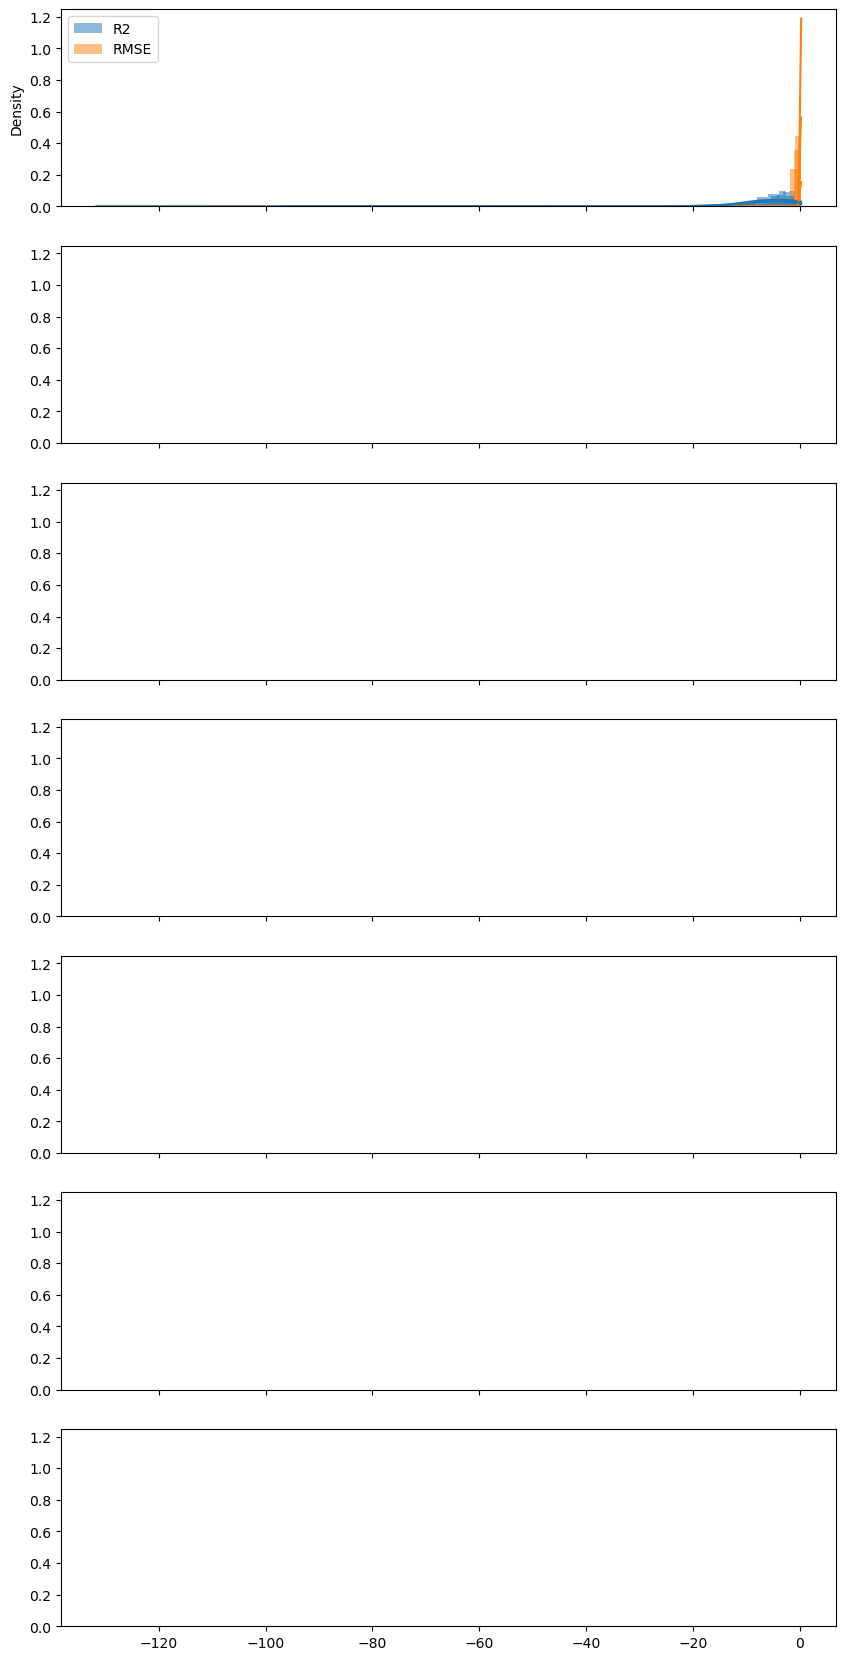

In [ ]:
plot_detR2(results, feature_set, target, profile_prefix, em_intype, s_site, 'R2')